# Performance analysis of PRS models for Caffeine Addiction
----

### Introduction
Now that the engine has calculated the PRS score per individual for each model, we need to assess if such scores are good predictors for caffeine addiction. This Notebook contains the computational setup, the results, and the conclusions of the analysis.

In [1]:
## First, we need to install the dependencies for the analysis
!pip install -qr requirements_notebook.txt

In [2]:
## Importing the dependencies
import numpy as np
import pandas as pd
import seaborn as sb
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

The results table is presented here. We can observe that the `caffeine_addiction` column is a binary variable, the `file_link` column contains the [openSNP](https://opensnp.org/) ID of the genotyped individual, and that there are two columns containing the PRS score calculated for each individual under the two different models provided.

In [3]:
## Reading the workflow results
results = pd.read_csv('workflow_results/prs_analysis_data.csv')
results

,caffeine_addiction,file_link,PRS_model_a,PRS_model_b
0,1,11008.23andme.9131,-0.666347,-0.766291
1,0,10787.ancestry.8931,0.290398,0.273421
2,0,10469.23andme.8739,0.437082,-0.085104
3,1,10420.23andme.8678,0.026507,-0.265804
4,1,6192.23andme.4696,0.532341,0.513710
5,1,9974.ancestry.8238,0.128651,-0.175686
6,1,9869.23andme.8128,0.274223,0.112793
7,0,8977.23andme.7322,0.020126,-0.305000
8,0,1.23andme.9,-0.033030,-0.224030
9,1,8655.ancestry.7006,-0.465127,-0.425039


----
### Performance of the models
The first step to evaluate the quality of the models is visualizing the distribution of PRSs for the two values of the `caffeine_addiction` variable under both models.


[Text(0.5, 0, 'Caffeine addiction (0 = No, 1 = Yes)')]

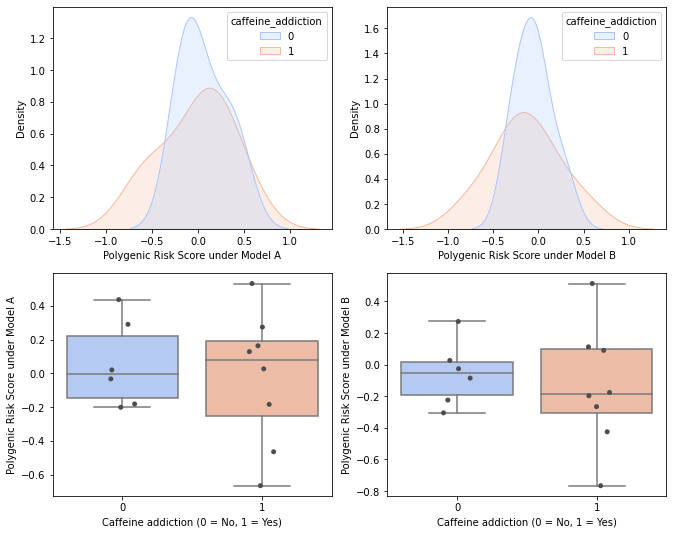

In [4]:
## Figures comparing the results of both models
fig, axs = plt.subplots(2, 2, figsize=(11,9))

sb.kdeplot(data=results, x='PRS_model_a', hue='caffeine_addiction', fill=True, common_norm=False, palette='coolwarm', ax=axs[0,0])
axs[0,0].set(xlabel="Polygenic Risk Score under Model A")
axs[0,0].set(ylabel="Density")

sb.kdeplot(data=results, x='PRS_model_b', hue='caffeine_addiction', fill=True, common_norm=False, palette='coolwarm', ax=axs[0,1])
axs[0,1].set(xlabel="Polygenic Risk Score under Model B")
axs[0,1].set(ylabel="Density")

sb.boxplot(data=results, x='caffeine_addiction', y='PRS_model_a', palette='coolwarm', ax=axs[1,0])
sb.stripplot(data=results, x='caffeine_addiction', y='PRS_model_a', color='.3', ax=axs[1,0])
axs[1,0].set(ylabel="Polygenic Risk Score under Model A")
axs[1,0].set(xlabel="Caffeine addiction (0 = No, 1 = Yes)")


sb.boxplot(data=results, x='caffeine_addiction', y='PRS_model_b', palette='coolwarm', ax=axs[1,1])
sb.stripplot(data=results, x='caffeine_addiction', y='PRS_model_b', color='.3', ax=axs[1,1])
axs[1,1].set(ylabel="Polygenic Risk Score under Model B")
axs[1,1].set(xlabel="Caffeine addiction (0 = No, 1 = Yes)")

The upper row of this visualization panel is a quick way to assess if the PRS distributions differ in both conditions for each model. In this case we can observe significant overlap of the PRS distributions for people with and without caffeine addiction for Model A and Model B; particularly in the area of greater density.

The lower row shows the specific PRS values for both models also compared by the `caffeine_addiction` value. Observing the difference in range of the PRS values, one could suggest that the extremes of the PRS distributions for no caffeine addiction in both models could be used as classification criterion. However, this would end in a very high rate of false negatives thus sacrificing the sensitivity of the model.

This is confirmed with the evidence below

In [5]:
## ANOVA comparison among both models 
aov_modA = pg.anova(data=results, dv='PRS_model_a', between='caffeine_addiction', detailed=True)
aov_modB = pg.anova(data=results, dv='PRS_model_b', between='caffeine_addiction', detailed=True)
print(aov_modA)
print(aov_modB)

               Source        SS  DF        MS        F    p-unc       np2
0  caffeine_addiction  0.021431   1  0.021431  0.18055  0.67842  0.014823
1              Within  1.424394  12  0.118700      NaN      NaN       NaN
               Source        SS  DF        MS         F     p-unc       np2
0  caffeine_addiction  0.023313   1  0.023313  0.224594  0.644067  0.018372
1              Within  1.245595  12  0.103800       NaN       NaN       NaN


Where upon statistical comparison of means between both conditions of each model, we can observe that the *p-values* are much greater than $\alpha$ = 0.025 (as per Bonferroni correction). Thus, null hypotheses of equal means between conditions cannot be rejected. In lay terms, this means that there are no statistical differences in the PRS values between people with and without caffeine addiction.

Logistic Regression was used as a final strategy to evaluate the accuracy of PRS models in a classification task.

In [6]:
## Examining the accuracy and the AUC of a Logistic Regression classifier
logisticRegr = LogisticRegression()
logisticRegr.fit(results['PRS_model_a'].to_numpy().reshape(-1,1), results['caffeine_addiction'].to_numpy())
out_predict = logisticRegr.predict(results['PRS_model_a'].to_numpy().reshape(-1,1))
out_predict_proba = logisticRegr.predict_proba(results['PRS_model_a'].to_numpy().reshape(-1,1))[::,1]
accuracy_model_a = metrics.accuracy_score(results['caffeine_addiction'].to_numpy(), out_predict)
auc_model_a = metrics.roc_auc_score(results['caffeine_addiction'].to_numpy(), out_predict)

logisticRegr = LogisticRegression()
logisticRegr.fit(results['PRS_model_b'].to_numpy().reshape(-1,1), results['caffeine_addiction'].to_numpy())
out_predict = logisticRegr.predict(results['PRS_model_b'].to_numpy().reshape(-1,1))
out_predict_proba = logisticRegr.predict_proba(results['PRS_model_b'].to_numpy().reshape(-1,1))[::,1]
accuracy_model_b = metrics.accuracy_score(results['caffeine_addiction'].to_numpy(), out_predict)
auc_model_b = metrics.roc_auc_score(results['caffeine_addiction'].to_numpy(), out_predict)

print("The Model A shows an accuracy of {accuracy}, and an AUC of {auc} when compared to its own dataset.".format(accuracy=accuracy_model_a, auc=auc_model_a))
print("The Model B shows an accuracy of {accuracy}, and an AUC of {auc} when compared to its own dataset.".format(accuracy=accuracy_model_b, auc=auc_model_b))


The Model A shows an accuracy of 0.5714285714285714, and an AUC of 0.5 when compared to its own dataset.
The Model B shows an accuracy of 0.5714285714285714, and an AUC of 0.5 when compared to its own dataset.


Here, in an exercise of classification with we observe that the accuracy and the AUC values are very close or equal to 0.5 in both models. This implies that *classifying individuals as having caffeine addiction or not with these PRS scores has an accuracy equivalent to a random guess.*

----
### Conclusion
**The models provided are not suitable for a clinical reporting of risk of developing caffeine addiction in patients. Future avenues for this research could be investigating a different set of variants for the condition and using more individuals for the sampling. An additional idea would be using a PRS model that is not a linear additive model, but instead a much more sophisticated strategy.**